In [1]:
import numpy as np
import os
import matplotlib.pylab as plt

from analysis_utils import get_group_pci, get_group_pci_product, get_neuron_selectivity, oneway_anova, zscore_dataset, find_selective_locations, find_non_selective_locations
from analysis_utils import get_trialwise_mean
from scipy import stats
from itertools import combinations
from pathlib import Path
from collections import defaultdict

import pickle
plt.style.use('default')

import itertools
import statsmodels.stats.multitest as smt

In [2]:
session_mapping = {"James":['20140904', '20140930', '20140828', '20140905'],
                   "Pancake":['20130923','20131014', '20130927'],# does not have FEF array
                   "Whiskey":['20200106','20200108', '20200109', '20200113', '20200115', '20200117', '20200120', '20200121']}

# Load monkey data

In [3]:
with open('monkey_data/'+'monkey_data.pkl', 'rb') as f:
    mapped_data_dictionary = pickle.load(f)
with open('monkey_data/'+'monkey_data_labels.pkl', 'rb') as f:
    mapped_data_dictionary_labels = pickle.load(f)
with open('monkey_data/'+'monkey_data_cell_names.pkl', 'rb') as f:
    mapped_cell_names = pickle.load(f)

# Selective Neurons Percentages

In [4]:
data_mapping = {'delay1':{5:[60+100,260+100], 10:[30+50,130+50], 20:[20,70], 50:[8,28]}, #50:[6+10,26+10], 100:[3+5,13+5]},
                'delay2':{5:[320+100,520+100], 10:[160+50, 260+50], 50:[34,54]},# 50:[32+10,52+10], 100:[16+5,26+5]}}
                'prestim':{5:[0,100], 10:[0,50], 50:[0,2], 100:[0,5], 150:[0,2], 250:[0,2],
                          20:[0,25], 30:[0,10], 40:[0,10], 60:[0,5], 70:[0,5], 80:[0,5], 90:[0,5],
                          110:[0,3], 120:[0,3], 130:[0,3], 140:[0,3], 160:[0,2], 170:[0,2], 180:[0,2], 190:[0,2], 200:[0,2],
                          210:[0,2], 220:[0,2], 230:[0,2], 240:[0,2]}}
trial_window = 'delay1'
counted_neurons_fef = defaultdict(int)
counted_neurons_dlpfc = defaultdict(int)
counted_neurons_fef_high = defaultdict(int)
counted_neurons_dlpfc_high = defaultdict(int)
counted_neurons_fef_high_uniq = defaultdict(int)
counted_neurons_dlpfc_high_uniq = defaultdict(int)

timebin_size=50

all_rates_fef = []
all_rates_lpfc = []

for sess in mapped_data_dictionary[timebin_size].keys():
    if 'James' in sess:
        monkey = 'James'
    if 'Pancake' in sess:
        monkey = 'Pancake'
    if 'Whiskey' in sess:
        monkey = 'Whiskey'

    high_cells = []

    if 'FEF' in sess:
        cell_names = np.array(mapped_cell_names[timebin_size][sess])
        counted_neurons_fef[monkey] += cell_names.shape[-1]
        
        spike_counts = np.sum(mapped_data_dictionary[timebin_size][sess][:, data_mapping[trial_window][timebin_size][0]:data_mapping[trial_window][timebin_size][1], :], axis=1)
        
        for cel in np.arange(spike_counts.shape[-1]):
            spk_rate_per_location = []
            for lc in np.unique(mapped_data_dictionary_labels[timebin_size][sess]):
                spk_rate_per_location.append(np.mean(spike_counts[np.where(mapped_data_dictionary_labels[timebin_size][sess]==lc)[0], cel]))
            if (np.array(spk_rate_per_location)>10).any():
                counted_neurons_fef_high[monkey] += 1
                high_cells.append(cel)
        
        uniq = np.unique([m.split('/')[-2] for m in cell_names[high_cells]])
        counted_neurons_fef_high_uniq[monkey] += uniq.shape[-1]
        
    if 'DLPFC' in sess:
        cell_names = np.array(mapped_cell_names[timebin_size][sess])
        counted_neurons_dlpfc[monkey] += cell_names.shape[-1]
        spike_counts = np.sum(mapped_data_dictionary[timebin_size][sess][:, data_mapping[trial_window][timebin_size][0]:data_mapping[trial_window][timebin_size][1], :], axis=1)
        for cel in np.arange(spike_counts.shape[-1]):
            spk_rate_per_location = []
            for lc in np.unique(mapped_data_dictionary_labels[timebin_size][sess]):
                spk_rate_per_location.append(np.mean(spike_counts[np.where(mapped_data_dictionary_labels[timebin_size][sess]==lc)[0], cel]))
            if (np.array(spk_rate_per_location)>10).any():
                counted_neurons_dlpfc_high[monkey] += 1
                high_cells.append(cel)

        uniq = np.unique([m.split('/')[-2] for m in cell_names[high_cells]])
        counted_neurons_dlpfc_high_uniq[monkey] += uniq.shape[-1]

for monkey in ['James', 'Pancake', 'Whiskey']:
    print("===================")
    print(monkey)
    print("FEF total neurons: ", counted_neurons_fef[monkey])
    print("FEF >10Hz neurons: ", counted_neurons_fef_high[monkey])
    print("FEF >10Hz neurons without doubles: ", counted_neurons_fef_high_uniq[monkey])

    print("LPFC total neurons: ", counted_neurons_dlpfc[monkey])
    print("LPFC >10Hz neurons: ", counted_neurons_dlpfc_high[monkey])
    print("LPFC >10Hz neurons without doubles: ", counted_neurons_dlpfc_high_uniq[monkey])


James
FEF total neurons:  79
FEF >10Hz neurons:  64
FEF >10Hz neurons without doubles:  54
LPFC total neurons:  42
LPFC >10Hz neurons:  27
LPFC >10Hz neurons without doubles:  23
Pancake
FEF total neurons:  5
FEF >10Hz neurons:  5
FEF >10Hz neurons without doubles:  5
LPFC total neurons:  43
LPFC >10Hz neurons:  33
LPFC >10Hz neurons without doubles:  32
Whiskey
FEF total neurons:  107
FEF >10Hz neurons:  76
FEF >10Hz neurons without doubles:  73
LPFC total neurons:  68
LPFC >10Hz neurons:  37
LPFC >10Hz neurons without doubles:  36


# Check Selectivity (weighted by neurons in each session)

In [5]:
delay1_2_map = {50:[18,28]}
method = 't-test-locations'


In [6]:
data_mapping.keys()

dict_keys(['delay1', 'delay2', 'prestim'])

In [7]:
total_neurons = defaultdict(int)
timebin_size = 50
trial_window = 'delay1'
counted_neurons_high = defaultdict(int)
counted_neurons_high_uniq = defaultdict(int)

session_selectivity = defaultdict(float)
recorded_neurons_in_region = {'DLPFC':91, 'FEF':132}
selective_filtered = defaultdict(list)

session_selective = defaultdict(list)
total_selective = defaultdict(int)
monkey_session_data = defaultdict(list)

for region in ['FEF', 'DLPFC']:
    total_selective[region]=0
    weighted_selectivity = []
    checked_sessions = []
    for session_key in mapped_data_dictionary[timebin_size].keys():
        session__ = '/'.join(session_key.split('/')[:-1])
        if session__ not in checked_sessions:
            region_neurons = 0
            if region == 'FEF':
                if 'Pancake' not in session_key:
                    for sub_region in ['/vFEF', '/dFEF']:
                        region_neurons += mapped_data_dictionary[timebin_size][session__+sub_region].shape[-1]
                elif '20130927' not in session_key:
                    region_neurons += mapped_data_dictionary[timebin_size][session__+'/FEF'].shape[-1]
                checked_sessions.append(session__)
            if region == 'DLPFC':
                if 'Pancake' in session_key:
                    for sub_region in ['/DLPFC', '/vDLPFC']:
                        region_neurons += mapped_data_dictionary[timebin_size][session__+sub_region].shape[-1]
                elif 'James' in session_key:
                    if '20140930' in session_key:
                        region_neurons += mapped_data_dictionary[timebin_size][session__+'/dDLPFC'].shape[-1]
                    else:
                        for sub_region in ['/dDLPFC', '/vDLPFC']:
                            region_neurons += mapped_data_dictionary[timebin_size][session__+sub_region].shape[-1]
                elif 'Whiskey' in session_key:
                    if '20200115' in session_key:
                        region_neurons += mapped_data_dictionary[timebin_size][session__+'/vDLPFC'].shape[-1]
                    elif '20200113' in session_key:
                        region_neurons += mapped_data_dictionary[timebin_size][session__+'/dDLPFC'].shape[-1]
                    else:
                        for sub_region in ['/dDLPFC', '/vDLPFC']:
                            region_neurons += mapped_data_dictionary[timebin_size][session__+sub_region].shape[-1]

        high_cells = []
        if region in session_key:
            total_neurons[region]+=mapped_data_dictionary[timebin_size][session_key].shape[-1]
            # remove doubles and filter >10Hz
            cell_names = np.array(mapped_cell_names[timebin_size][session_key])
            spike_counts = np.sum(mapped_data_dictionary[timebin_size][session_key][:, data_mapping[trial_window][timebin_size][0]:data_mapping[trial_window][timebin_size][1], :], axis=1)
            
            for cel in np.arange(spike_counts.shape[-1]):
                spk_rate_per_location = []
                for lc in np.unique(mapped_data_dictionary_labels[timebin_size][session_key]):
                    spk_rate_per_location.append(np.mean(spike_counts[np.where(mapped_data_dictionary_labels[timebin_size][session_key]==lc)[0], cel]))
                if (np.array(spk_rate_per_location)>10).any():
                    counted_neurons_high[region] += 1
                    high_cells.append(cel)
            uniq = np.unique([m.split('/')[-2] for m in cell_names[high_cells]])
            counted_neurons_high_uniq[region] += uniq.shape[-1]
            # if there are neurons with high firing rate in the session
            if uniq.shape[-1] > 0:
                selective_filtered[session_key] = get_neuron_selectivity(mapped_data_dictionary[timebin_size][session_key][:, delay1_2_map[timebin_size][0]:delay1_2_map[timebin_size][1], high_cells],
                                                                         mapped_data_dictionary_labels[timebin_size][session_key], method=method,
                                                                         prestim_dataset=mapped_data_dictionary[timebin_size][session_key][:, data_mapping['prestim'][timebin_size][0]:data_mapping['prestim'][timebin_size][1], high_cells])

                flatten_selective = []
                for loc in selective_filtered[session_key].keys():
                    flatten_selective.append(selective_filtered[session_key][loc].tolist())
                # number of neurons that are selective in the session
                session_selective[session_key] = len(np.unique(list(itertools.chain.from_iterable(flatten_selective))))
                # calculate the selective neurons for all sessions per region 
                total_selective[region] += session_selective[session_key]
                # calculate the selectivity percentage of the session as the following division:
                # (selective neurons of the session / high rating neurons recorded in the session)
                session_selectivity[session_key] = session_selective[session_key]/uniq.shape[-1]
                # calculate the percentage of selectivity that each session is responsible to the whole population of neurons
                percentage_of_recorded_neurons =  uniq.shape[-1]/recorded_neurons_in_region[region]
                selective_neurons_percentage = percentage_of_recorded_neurons * session_selectivity[session_key]
                weighted_selectivity.append(selective_neurons_percentage)
                
                print(session_key)
                print('Session trials: ', mapped_data_dictionary[timebin_size][session_key].shape[0])
                print('Session neurons: ', mapped_data_dictionary[timebin_size][session_key].shape[-1])
                print('Region neurons: ', region_neurons)

                print('Session >10Hz recorded neurons: ', uniq.shape[-1])
                print('Session selective neurons: ', len(np.unique(list(itertools.chain.from_iterable(flatten_selective)))))
                print("Session selectivity percentage: ", session_selectivity[session_key])
                print('Session selective neurons percentage: ', selective_neurons_percentage)
                monkey_session_data[region].append([mapped_data_dictionary[timebin_size][session_key].shape[0],
                                                    percentage_of_recorded_neurons,
                                                    region_neurons])

            
    print(region,' all neurons: ' , total_neurons[region])
    print(region, ' >10Hz no doubles: ' , counted_neurons_high_uniq[region])
    print('Selective neurons: ', total_selective[region])
    print('Total Selectivity: ', np.sum(weighted_selectivity))

James/20140904/session01/vFEF
Session trials:  481
Session neurons:  3
Region neurons:  24
Session >10Hz recorded neurons:  3
Session selective neurons:  2
Session selectivity percentage:  0.6666666666666666
Session selective neurons percentage:  0.015151515151515152
James/20140904/session01/dFEF
Session trials:  481
Session neurons:  21
Region neurons:  24
Session >10Hz recorded neurons:  12
Session selective neurons:  3
Session selectivity percentage:  0.25
Session selective neurons percentage:  0.022727272727272728
James/20140930/session01/vFEF
Session trials:  365
Session neurons:  4
Region neurons:  17
Session >10Hz recorded neurons:  4
Session selective neurons:  3
Session selectivity percentage:  0.75
Session selective neurons percentage:  0.022727272727272728
James/20140930/session01/dFEF
Session trials:  365
Session neurons:  13
Region neurons:  17
Session >10Hz recorded neurons:  8
Session selective neurons:  2
Session selectivity percentage:  0.25
Session selective neurons p

#### FEF selectivity 46%
#### DLPFC selectivity 39%

In [8]:
# np.save('saved_results/'+'monkey_session_selectivity_trial_data.npy', monkey_session_data)

# Noise Correlation Analysis

In [9]:
timebin_ylim_mapping = defaultdict(dict)

Session: James/20140904/session01/vFEF
Session: James/20140904/session01/dFEF
Session: James/20140930/session01/vFEF
Session: James/20140930/session01/dFEF
Session: James/20140828/session01/vFEF
Session: James/20140828/session01/dFEF
Session: James/20140905/session01/vFEF
Session: James/20140905/session01/dFEF
Session: Pancake/20130923/session01/FEF
Session: Pancake/20131014/session01/FEF
Session: Whiskey/20200106/session02/dFEF
Session: Whiskey/20200106/session02/vFEF
Session: Whiskey/20200108/session03/dFEF
Session: Whiskey/20200108/session03/vFEF
Session: Whiskey/20200109/session04/dFEF
Session: Whiskey/20200109/session04/vFEF
Session: Whiskey/20200113/session01/dFEF
Session: Whiskey/20200113/session01/vFEF
Session: Whiskey/20200115/session03/dFEF
Session: Whiskey/20200115/session03/vFEF
Session: Whiskey/20200117/session03/dFEF
Session: Whiskey/20200117/session03/vFEF
Session: Whiskey/20200120/session01/dFEF
Session: Whiskey/20200120/session01/vFEF
Session: Whiskey/20200121/session0

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


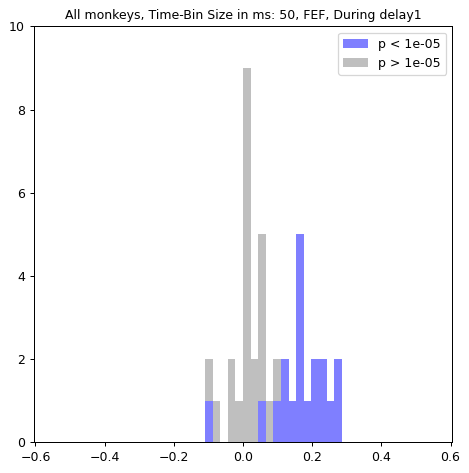

Session: James/20140904/session01/vDLPFC
Session: James/20140904/session01/dDLPFC
Session: James/20140930/session01/dDLPFC
Session: James/20140828/session01/vDLPFC
Session: James/20140828/session01/dDLPFC
Session: James/20140905/session01/vDLPFC
Session: James/20140905/session01/dDLPFC
Session: Pancake/20130923/session01/DLPFC
Session: Pancake/20130923/session01/vDLPFC
Session: Pancake/20131014/session01/DLPFC
Session: Pancake/20131014/session01/vDLPFC
Session: Pancake/20130927/session01/DLPFC
Session: Pancake/20130927/session01/vDLPFC
Session: Whiskey/20200106/session02/dDLPFC
Session: Whiskey/20200106/session02/vDLPFC
Session: Whiskey/20200108/session03/dDLPFC
Session: Whiskey/20200108/session03/vDLPFC
Session: Whiskey/20200109/session04/dDLPFC
Session: Whiskey/20200109/session04/vDLPFC
Session: Whiskey/20200113/session01/dDLPFC
Session: Whiskey/20200115/session03/vDLPFC
Session: Whiskey/20200117/session03/dDLPFC
Session: Whiskey/20200117/session03/vDLPFC
Session: Whiskey/20200120/se

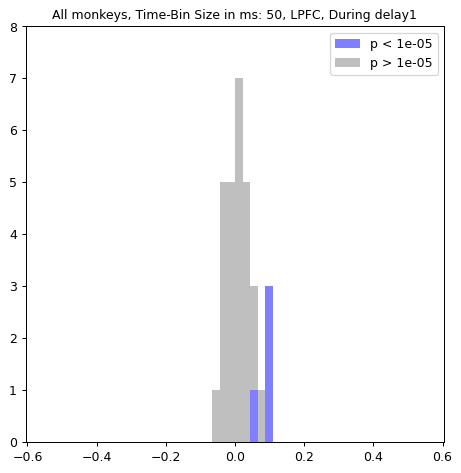

In [10]:
# set significance levels for correlations
significance_level1 = 1e-5

plot_title = '{monkey}, Time-Bin Size in ms: {timebin_size}, {arrays}, During {window}'
method = 't-test-locations'
distributions = {}
threshold = 10 # in Hz
hist_bins  = 50
histogram_xrange = [-0.55, 0.55]
bar_width = 0.4

# second half of delay1 mapping (to decide selectivity)
# delay1_2_map = {5:[160+100,260+100], 10:[80+50,130+50], 50:[16+10,26+10], 100:[8+5,13+5], 150:[6+2,9+2], 250:[3+2,5+2]}
delay1_2_map = {50:[18,28]}
# time windows mapping
data_mapping = {'delay1':{50:[8,28]},
                'delay2':{50:[34,54]},
                'response':{50:[54,-1]},
                'target':{50:[2,8]},
                'distractor':{50:[28,34]},
                'prestim':{50:[0,2]},
                'full':{50:[0,-1]} }
save=False
region_low_correlations = defaultdict(lambda: defaultdict(dict))
region_medium_correlations = defaultdict(lambda: defaultdict(dict))
region_high_correlations = defaultdict(lambda: defaultdict(dict))

region_low_pvalues = defaultdict(lambda: defaultdict(dict))
region_medium_pvalues = defaultdict(lambda: defaultdict(dict))
region_high_pvalues = defaultdict(lambda: defaultdict(dict))

region_low_pairs = defaultdict(lambda: defaultdict(dict))
region_medium_pairs = defaultdict(lambda: defaultdict(dict))
region_high_pairs = defaultdict(lambda: defaultdict(dict))
selective =  defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

timeseries_lengths = defaultdict(list)
cell_spike_rates = defaultdict(list)

all_checked_pairs = defaultdict(lambda: defaultdict(dict))
all_checked_pairs_tested = defaultdict(lambda: defaultdict(dict))

all_p_values = defaultdict(lambda: defaultdict(dict))
all_neurons = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
all_neurons2 = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
all_neurons_full = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
all_neurons_full_labels = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
all_neurons_full_selective_locations = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# to save monkey data for cross temporal decoding
monkey_session_checked_neurons=defaultdict(dict)
monkey_session_p_values=defaultdict(dict)
monkey_session_correlations=defaultdict(dict)

for i, timebin_size in enumerate([50]):
    for array in ['FEF','LPFC']:
        for trial_window in ['delay1']:
            all_low_p = []
            all_high_p = []

            flatten_pairs = []
            all_low_pairs = []
            all_high_pairs = []
            
            all_low_pvalues = []
            all_high_pvalues = []

            for session_key in mapped_data_dictionary[timebin_size].keys():
                if array in session_key:# and 'WangZi' not in session_key:
                    if mapped_data_dictionary[timebin_size][session_key].shape[0] == 0:
                        print("Skipped session: ", session_key)
                        continue
                    else:
                        print("Session:", session_key)

                    trial_indxs = np.arange(mapped_data_dictionary[timebin_size][session_key].shape[0])
                    data = mapped_data_dictionary[timebin_size][session_key][:, data_mapping[trial_window][timebin_size][0]:data_mapping[trial_window][timebin_size][1], :]
                    data_full = mapped_data_dictionary[timebin_size][session_key]
                    # get the mean of each trial for all neurons
                    data_spike_counts = np.sum(data, axis=1)
                    timebins = data.shape[1]
                    data_labels = mapped_data_dictionary_labels[timebin_size][session_key]

                    zscored_data = zscore_dataset(data, data_labels)
                    zscored_data_full = zscore_dataset(data_full, data_labels)
                
                    pair_correlations = []
                    p_values = []
                    checked_pairs = []
                    checked_singles = []
                    full_pairs = []
                    selective_combinations = []
                    highest_spike_rate = {}

                    selective[timebin_size][trial_window][session_key] = get_neuron_selectivity(mapped_data_dictionary[timebin_size][session_key][:, delay1_2_map[timebin_size][0]:delay1_2_map[timebin_size][1], :],
                                                                                                data_labels, method=method, anova_significance_p=0.01, ttest_significance_p=0.01,
                                                                                               prestim_dataset=mapped_data_dictionary[timebin_size][session_key][:, data_mapping['prestim'][timebin_size][0]:data_mapping['prestim'][timebin_size][1], :])

                    for key_stim in selective[timebin_size][trial_window][session_key].keys():
                        selective_combinations+=list(combinations(selective[timebin_size][trial_window][session_key][key_stim],2))

                    if selective_combinations:
                        for pair in selective_combinations:
                            # check the chanells of the neurons in the pair
                            channel1 = mapped_cell_names[timebin_size][session_key][pair[0]].split('/')[4]
                            channel2 = mapped_cell_names[timebin_size][session_key][pair[1]].split('/')[4]
                            # if the cells come from different channels proceed with analysis
                            if channel1 != channel2:
                                # if we have not check that pair combination
                                if pair+tuple([mapped_cell_names[timebin_size][session_key][pair[0]], mapped_cell_names[timebin_size][session_key][pair[1]]]) not in checked_pairs:
                                    # find the overlapping locations of the pair cells
                                    overlaping_locs = [loc for loc in find_selective_locations(pair[0], pair[1], selective[timebin_size][trial_window][session_key])]
                                    # if there is overlap between the two cells
                                    if len(overlaping_locs)!=0:
                                        all_trials = np.array([])
                                        for all_loc in overlaping_locs:
                                            all_trials = np.concatenate([all_trials,np.where(data_labels==all_loc)[0]])
                                        all_trials = all_trials.astype(int)
                                        # get the mean activities of the cells in the pair (to decide on a threshold based on their distribution)
                                        for cell in pair:
                                            for monkey_name in ['James', 'Pancake', 'Whiskey']:
                                                if monkey_name in session_key:
                                                    spike_rate_per_location = []
                                                    for lc in overlaping_locs:
                                                        spike_rate_per_location.append(np.mean(data_spike_counts[np.where(data_labels==lc)[0], cell]))
                                                        highest_spike_rate[cell] = np.max(spike_rate_per_location)
                                                        cell_spike_rates[timebin_size, trial_window, monkey_name, array].append(np.max(spike_rate_per_location))
                                        # if the cells exceeds the threshold
                                        if highest_spike_rate[pair[0]]>=threshold and highest_spike_rate[pair[1]]>=threshold:
                                            stiched_zscored_neuron_trials = np.zeros((2, timebins*all_trials.shape[0]))
                                            for n, neuron in enumerate(pair):
                                                # use pre zscored data
                                                stiched_zscored_neuron_trials[n, :] = zscored_data[all_trials, :, neuron].reshape(-1)
                                            # find the nan valued trials after zscoring and exclude them from the calculation of correlation 
                                            nan_idxs = np.concatenate([np.where(np.isnan(stiched_zscored_neuron_trials[0,:]))[0],
                                                            np.where(np.isnan(stiched_zscored_neuron_trials[1,:]))[0]])
                                            mask=np.full(stiched_zscored_neuron_trials.shape[1], True)
                                            mask[nan_idxs]=False
                                            # calculate pair correlation between the two neurons 
                                            pci, p_value = stats.pearsonr(stiched_zscored_neuron_trials[0, mask], stiched_zscored_neuron_trials[1, mask])
                                            pair_correlations.append(pci)
                                            p_values.append(p_value)
                                            checked_pairs.append(pair+tuple([mapped_cell_names[timebin_size][session_key][pair[0]],
                                                                             mapped_cell_names[timebin_size][session_key][pair[1]]]))
                                            for neuron in pair:
                                                if neuron not in checked_singles:
                                                    checked_singles.append(neuron)
                                                    all_neurons[timebin_size][array][trial_window].append(data[all_trials,:,neuron])
                                                    all_neurons2[timebin_size][array][trial_window].append(data[:,:,neuron])
                                                    all_neurons_full[timebin_size][array][trial_window].append(mapped_data_dictionary[timebin_size][session_key][:,:,neuron])
                                                    all_neurons_full_labels[timebin_size][array][trial_window].append(mapped_data_dictionary_labels[timebin_size][session_key])
                                                    nn_locations_ = []
                                                    for location_ in selective[timebin_size][trial_window][session_key].keys():
                                                        if neuron in selective[timebin_size][trial_window][session_key][location_]:
                                                            nn_locations_.append(location_)
                                                    all_neurons_full_selective_locations[timebin_size][array][trial_window].append(nn_locations_)
                                            # keep the lengths of the timeseries that take part in the analysis (along with the cell names)
                                            # to compare distributions among monkeys
                                            for monkey_name in ['James', 'Pancake', 'Whiskey', 'WangZi']:
                                                if monkey_name in session_key:
                                                    timeseries_lengths[timebin_size, trial_window, monkey_name, array].append((stiched_zscored_neuron_trials[0, mask].shape[0],                                                                                                                               mapped_cell_names[timebin_size][session_key][pair[0]],
                                                                                                                               mapped_cell_names[timebin_size][session_key][pair[1]]))
                    all_checked_pairs[timebin_size][trial_window][session_key] = np.array(checked_pairs)
                    all_p_values[timebin_size][trial_window][session_key] = np.array(p_values)
                    pair_correlations = np.array(pair_correlations)
                    p_values = np.array(p_values)
                    checked_pairs = np.array(checked_pairs)
                    
                    low_pvalues = p_values[np.where(p_values<significance_level1)]
                    high_pvalues = p_values[np.where(p_values>=significance_level1)]
            
                    low_p = pair_correlations[np.where(p_values<significance_level1)]
                    high_p = pair_correlations[np.where(p_values>=significance_level1)]

                    low_pairs = checked_pairs[np.where(p_values<significance_level1)]
                    high_pairs = checked_pairs[np.where(p_values>=significance_level1)]
    
                    all_low_p.append(low_p)
                    all_high_p.append(high_p)

                    all_low_pairs.append(low_pairs)
                    all_high_pairs.append(high_pairs)
                    
                    all_low_pvalues.append(low_pvalues)
                    all_high_pvalues.append(high_pvalues)
                    
                    # collect checked pairs, their correlations and p-values for each session
                    # (to use in cross temporal decoding)
                    monkey_session_checked_neurons[timebin_size][session_key] = np.array(checked_pairs)
                    monkey_session_p_values[timebin_size][session_key] = np.array(p_values)
                    monkey_session_correlations[timebin_size][session_key] = pair_correlations
                    
            all_low_p_flatten = np.array([item for sublist in all_low_p for item in sublist])
            all_high_p_flatten = np.array([item for sublist in all_high_p for item in sublist])
            
            all_low_pvalues_flatten = np.array([item for sublist in all_low_pvalues for item in sublist])
            all_high_pvalues_flatten = np.array([item for sublist in all_high_pvalues for item in sublist])
            print("Pairs: ", len(all_low_p_flatten)+len(all_high_p_flatten))
            print("Mean correlation of significant pairs: ", np.mean(all_low_p_flatten[all_low_p_flatten>0]))

            region_low_correlations[trial_window][array][timebin_size] = all_low_p_flatten.copy()
            region_high_correlations[trial_window][array][timebin_size] = all_high_p_flatten.copy()
            
            region_low_pvalues[trial_window][array][timebin_size] = all_low_pvalues_flatten.copy()
            region_high_pvalues[trial_window][array][timebin_size] = all_high_pvalues_flatten.copy()

            region_low_pairs[trial_window][array][timebin_size] = np.array([item for sublist in all_low_pairs for item in sublist])
            region_high_pairs[trial_window][array][timebin_size] = np.array([item for sublist in all_high_pairs for item in sublist])

            distributions[array] = np.concatenate([all_low_p_flatten, all_high_p_flatten])

            plt.figure(figsize=(6,6), dpi=90)
            plt.title(plot_title.format(monkey='All monkeys', timebin_size=timebin_size, arrays=array, window=trial_window), fontdict = {'fontsize' : 10})
            yy,_,_=plt.hist([all_low_p_flatten, all_high_p_flatten],  color=['blue', 'grey'],
                         stacked=True, bins=hist_bins, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                         label=['p < '+str(significance_level1),
                                'p > '+str(significance_level1)]);
            timebin_ylim_mapping[timebin_size][array] = yy.max()+1
            plt.ylim(0,yy.max()+1)
            plt.legend();
            plt.show()


# Save monkey session full data to use later for Cross Temporal decoding

In [11]:
monkey_session_all_neurons=defaultdict(lambda: defaultdict(list))
monkey_session_all_data_labels = {}
monkey_session_checked_pairs=defaultdict(lambda: defaultdict(list))
monkey_session_significant_neurons=defaultdict(lambda: defaultdict(list))
monkey_session_non_significant_neurons=defaultdict(lambda: defaultdict(list))

timebin=50
monkeys=['James', 'Pancake', 'Whiskey']
for array in ['FEF', 'DLPFC']:
    for session_key in mapped_data_dictionary[timebin].keys():
#         print(session_key)
        monkey_session_all_data_labels['/'.join(session_key.split('/')[:-1])]=mapped_data_dictionary_labels[timebin][session_key]
        if array in session_key:
            monkey_session_all_neurons['/'.join(session_key.split('/')[:-1])][array].append(mapped_data_dictionary[timebin][session_key])
            if monkey_session_checked_neurons[timebin][session_key].size!=0:
                print(session_key)
                monkey_session_checked_pairs['/'.join(session_key.split('/')[:-1])][array].append(mapped_data_dictionary[timebin][session_key][:,:,
                                                                                                                                          np.unique(monkey_session_checked_neurons[timebin][session_key][:,:2].astype(int))])
                monkey_session_significant_neurons['/'.join(session_key.split('/')[:-1])][array].append(mapped_data_dictionary[timebin][session_key][:,:,
                                                                                                                            np.unique(monkey_session_checked_neurons[timebin][session_key][np.where(monkey_session_p_values[timebin][session_key]<significance_level1)[0],:2].astype(int))])
                # create a list for each selective neuron in the session with the p-values of
                # the pairs it takes part in
                neuron_pvalues = defaultdict(list)
                for j, pair in enumerate(monkey_session_checked_neurons[timebin][session_key]):
                    for neuron in pair[:2]:
                        neuron_pvalues[int(neuron)].append(monkey_session_p_values[timebin][session_key][j])
                print(neuron_pvalues, '\n')
                # keep the neurons with high pvalues
                non_significant_neurons = []
                for k in neuron_pvalues.keys():
                    if np.min(neuron_pvalues[k])>=significance_level1:
                        non_significant_neurons.append(k)
                monkey_session_non_significant_neurons['/'.join(session_key.split('/')[:-1])][array].append(mapped_data_dictionary[timebin][session_key][:,:,non_significant_neurons])

monkey_session_all_data = defaultdict(dict)
monkey_session_checked_pairs_data = defaultdict(dict)
monkey_session_significant_neurons_data = defaultdict(dict)
monkey_session_non_significant_neurons_data = defaultdict(dict)

for k in monkey_session_all_neurons.keys():
    for array in ['FEF', 'DLPFC']:
        if monkey_session_all_neurons[k][array]:
            monkey_session_all_data[array][k]=np.concatenate(monkey_session_all_neurons[k][array], axis=2)  
            if monkey_session_checked_pairs[k][array]:
                monkey_session_checked_pairs_data[array][k]=np.concatenate(monkey_session_checked_pairs[k][array], axis=2)  
                monkey_session_significant_neurons_data[array][k]=np.concatenate(monkey_session_significant_neurons[k][array], axis=2)
                monkey_session_non_significant_neurons_data[array][k]=np.concatenate(monkey_session_non_significant_neurons[k][array], axis=2)

            

James/20140904/session01/vFEF
defaultdict(<class 'list'>, {0: [2.9213254543404177e-61], 2: [2.9213254543404177e-61]}) 

James/20140904/session01/dFEF
defaultdict(<class 'list'>, {16: [6.567221683588453e-07], 20: [6.567221683588453e-07, 9.255295274396502e-23], 19: [9.255295274396502e-23]}) 

James/20140930/session01/vFEF
defaultdict(<class 'list'>, {0: [1.4887386155441416e-19, 5.363712753660642e-20], 1: [1.4887386155441416e-19, 1.0857185775121864e-09], 3: [5.363712753660642e-20, 1.0857185775121864e-09]}) 

James/20140828/session01/vFEF
defaultdict(<class 'list'>, {0: [1.1934638523556845e-18], 1: [1.1934638523556845e-18]}) 

James/20140828/session01/dFEF
defaultdict(<class 'list'>, {0: [1.1155363488517618e-05, 8.138970003920295e-09, 0.002688210315485241], 13: [1.1155363488517618e-05, 1.0995866139864563e-18, 4.387128965689152e-17], 12: [8.138970003920295e-09, 1.0995866139864563e-18, 1.8840682487543667e-15], 16: [0.002688210315485241, 1.8840682487543667e-15, 4.387128965689152e-17]}) 

Jame

In [12]:
with open('saved_results/'+'monkey_session_all_data.pkl', 'wb') as f:
    pickle.dump(monkey_session_all_data, f)
with open('saved_results/'+'monkey_session_all_data_labels.pkl', 'wb') as f:
    pickle.dump(monkey_session_all_data_labels, f)
    
with open('saved_results/'+'monkey_session_checked_pairs_data.pkl', 'wb') as f:
    pickle.dump(monkey_session_checked_pairs_data, f)
with open('saved_results/'+'monkey_session_significant_neurons_data.pkl', 'wb') as f:
    pickle.dump(monkey_session_significant_neurons_data, f)
with open('saved_results/'+'monkey_session_non_significant_neurons_data.pkl', 'wb') as f:
    pickle.dump(monkey_session_non_significant_neurons_data, f)

# Example neurons selectivity plots

[ 7  8  9 12 14 17 18]
[12, 17, 18]


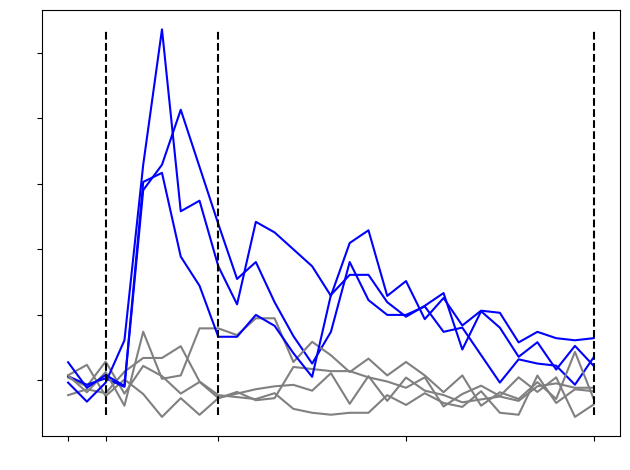

[0 1 2 3]
[3, 1]


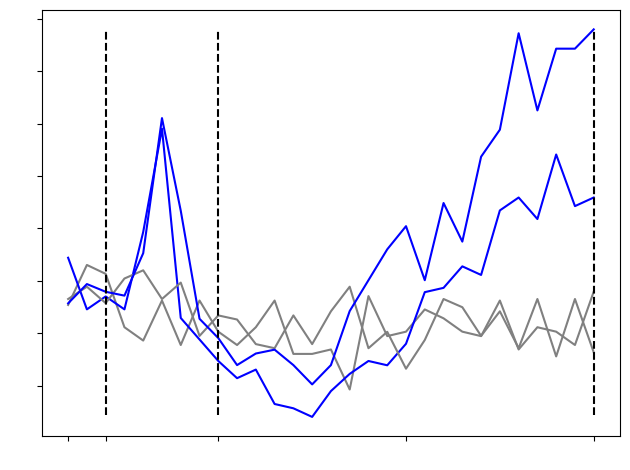

In [13]:
# plt.style.use('default')
for region in ['FEF']:#, 'LPFC']:
    for nn in [11,28]:
        selective_neuron_means = get_trialwise_mean(all_neurons_full[50][region]['delay1'][nn],
                                                all_neurons_full_labels[50][region]['delay1'][nn])
        print(np.unique(all_neurons_full_labels[50][region]['delay1'][nn]))
        unique_labels_ = np.unique(all_neurons_full_labels[50][region]['delay1'][nn])
        print(all_neurons_full_selective_locations[50][region]['delay1'][nn])
        for ii, neuron_mean_ in enumerate(selective_neuron_means):
            if unique_labels_[ii] in all_neurons_full_selective_locations[50][region]['delay1'][nn]:
                color_ = 'blue'
                label_ = 'selective'
            else:
                color_ = 'gray'
                label_ = 'non-selective'
            plt.plot(neuron_mean_[:29], color=color_, label=label_)
    
        plt.axvline(x=2, ymax=0.95, ymin=0.05, linestyle='--', color='black')
        plt.axvline(x=8, ymax=0.95, ymin=0.05, linestyle='--', color='black')
        plt.axvline(x=28, ymax=0.95, ymin=0.05, linestyle='--', color='black')

        plt.xticks([0,2,8,18,28],['-150','','300','800','1300'])
        plt.xticks(color='w')
        plt.yticks(color='w')

        plt.tight_layout()
#         plt.savefig('eps_images-new/'+'example-neuron-plot-'+str(nn)+'.pdf', format='pdf')
        plt.show()#[2, 8, 28, 34, 54]


# DLPFC P-VALUES after Bonferroni

In [14]:
method='bonferroni'#'fdr_bh'
bool_bonf_ , _, _,corrected_bonf_alpha = smt.multipletests(np.concatenate([region_high_pvalues['delay1']['LPFC'][50],
                                                        region_low_pvalues['delay1']['LPFC'][50]]),
                                        alpha=significance_level1,
                                        method=method)

In [15]:
bool_bonf_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True])

In [16]:
region_high_pvalues['delay1']['LPFC'][50]

array([1.29711364e-01, 1.75306403e-04, 4.51530693e-02, 7.80247393e-01,
       1.64326195e-01, 2.63173715e-05, 7.51273101e-01, 7.38657922e-02,
       2.92129995e-01, 6.48749513e-01, 1.30727406e-02, 3.79598525e-01,
       2.92329113e-02, 7.34960973e-01, 4.54557949e-01, 6.49250101e-01,
       1.78230367e-01, 3.09779601e-02, 9.76754032e-01, 2.28838764e-01,
       9.93048521e-01, 2.48326785e-01, 3.92589978e-01, 5.53987510e-01,
       2.62729431e-02, 8.69739081e-02])

In [17]:
region_low_pvalues['delay1']['LPFC'][50]

array([1.67929583e-09, 4.67647925e-07, 8.52049717e-12, 2.32370039e-08])

In [18]:
significant_pairs_text='Significant Pairs Percentage: {}, ({}/{})'
significant_cells_text='Significant Cells Percentage: {}, ({}/{})'

                
unique_cells = defaultdict(list)
unique_significant_cells = defaultdict(list)
number_of_pairs = 0
number_of_significant_pairs = 0

number_of_neurons = 0
number_of_significant_neurons = 0
for session_key in ['Pancake/20130923', 'Pancake/20131014', 'Pancake/20130927', 'James/20140904']:
    for p, pair_ in enumerate(np.concatenate([region_high_pairs['delay1']['LPFC'][50],
                                 region_low_pairs['delay1']['LPFC'][50]])):
        if session_key in pair_[2]:
            number_of_pairs+=1
            if bool_bonf_[p]:
                number_of_significant_pairs+=1
            
            for neuron_ in [pair_[0], pair_[1]]:
                if neuron_ not in unique_cells[session_key]:
                    unique_cells[session_key].append(neuron_)
                if bool_bonf_[p] and neuron_ not in unique_significant_cells[session_key]:
                    unique_significant_cells[session_key].append(neuron_)
        
    number_of_neurons+=len(unique_cells[session_key])
    number_of_significant_neurons+=len(unique_significant_cells[session_key])

print(significant_pairs_text.format(number_of_significant_pairs/number_of_pairs, number_of_significant_pairs, number_of_pairs))
print(significant_cells_text.format(number_of_significant_neurons/number_of_neurons , number_of_significant_neurons, number_of_neurons))


Significant Pairs Percentage: 0.1, (3/30)
Significant Cells Percentage: 0.29411764705882354, (5/17)


In [19]:
region_high_correlations['delay1']['LPFC'][50]

array([ 0.0298391 ,  0.06628267,  0.03541509,  0.00698029, -0.02458966,
        0.05859093, -0.0079301 ,  0.0316023 ,  0.01469667, -0.01139604,
       -0.04386813,  0.01643564, -0.03854391, -0.00846981,  0.01257309,
        0.00764663, -0.03367237, -0.04006228, -0.00072008,  0.03392461,
        0.00033472, -0.04976299, -0.0162209 ,  0.01223995,  0.04112301,
        0.04450599])

In [20]:
region_low_correlations['delay1']['LPFC'][50]

array([0.10626774, 0.06061921, 0.08905728, 0.09371197])

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


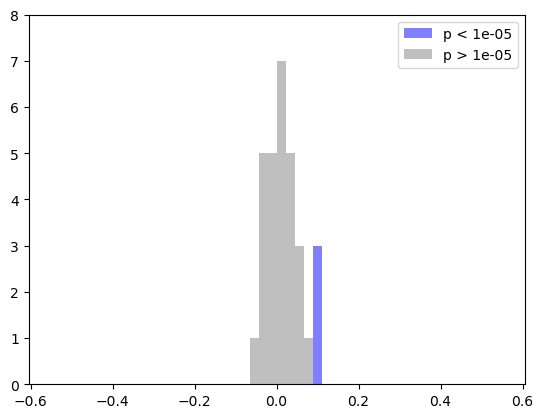

In [21]:
# Manually plot the corrected bonferroni pairs. Kept only the three of the four significant pairs.
yy,_,_=plt.hist([[0.10626774, 0.08905728, 0.09371197],
                 [ 0.0298391 ,  0.06628267,  0.03541509,  0.00698029, -0.02458966,
        0.05859093, -0.0079301 ,  0.0316023 ,  0.01469667, -0.01139604,
       -0.04386813,  0.01643564, -0.03854391, -0.00846981,  0.01257309,
        0.00764663, -0.03367237, -0.04006228, -0.00072008,  0.03392461,
        0.00033472, -0.04976299, -0.0162209 ,  0.01223995,  0.04112301,
        0.04450599, 0.06061921]],  color=['blue', 'grey'],
                         stacked=True, bins=hist_bins, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                         label=['p < '+str(significance_level1),
                                'p > '+str(significance_level1)]);
timebin_ylim_mapping[timebin_size][array] = yy.max()+1
plt.ylim(0,yy.max()+1)
plt.legend();
plt.show()

# FEF P-Values after Bonferroni

In [22]:
method='bonferroni'
bool_bonf_ , _, _,corrected_bonf_alpha = smt.multipletests(np.concatenate([region_high_pvalues['delay1']['FEF'][50],
                                                        region_low_pvalues['delay1']['FEF'][50]]),
                                        alpha=significance_level1,
                                        method=method)

In [23]:
bool_bonf_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True, False])

In [24]:
region_low_pvalues['delay1']['FEF'][50]

array([2.92132545e-61, 6.56722168e-07, 9.25529527e-23, 1.48873862e-19,
       5.36371275e-20, 1.08571858e-09, 1.19346385e-18, 8.13897000e-09,
       1.09958661e-18, 1.88406825e-15, 4.38712897e-17, 2.41774131e-76,
       7.43950497e-06, 6.12201909e-12, 7.36162811e-06, 2.15852020e-16,
       6.95267742e-21, 6.20084764e-09, 6.38664877e-06])

In [25]:
region_high_pvalues['delay1']['FEF'][50]

array([1.11553635e-05, 2.68821032e-03, 2.61511642e-01, 1.65985481e-02,
       9.57834833e-01, 8.39592330e-04, 7.77863868e-01, 6.56505769e-01,
       3.43506399e-01, 6.43633297e-01, 3.85220571e-01, 5.36181749e-01,
       7.58155667e-01, 6.86909551e-01, 1.54776850e-05, 1.72019922e-03,
       3.19881347e-01, 4.85726484e-01, 1.61940138e-01, 6.58616321e-04,
       4.73920803e-03, 2.70152685e-01])

In [26]:
significant_pairs_text='Significant Pairs Percentage: {}, ({}/{})'
significant_cells_text='Significant Cells Percentage: {}, ({}/{})'

                
unique_cells = defaultdict(list)
unique_significant_cells = defaultdict(list)
number_of_pairs = 0
number_of_significant_pairs = 0

number_of_neurons = 0
number_of_significant_neurons = 0
for session_key in ['James/20140828', 'Pancake/20130923', 'James/20140930','Whiskey/20200106', 'Whiskey/20200108',
                    'Whiskey/20200109', 'Whiskey/20200113', 'Whiskey/20200115', 'Whiskey/20200120', 'Whiskey/20200121',
                   'James/20140904','James/20140905']:
    for p, pair_ in enumerate(np.concatenate([region_high_pairs['delay1']['FEF'][50],
                                 region_low_pairs['delay1']['FEF'][50]])):
        if session_key in pair_[2]:
            number_of_pairs+=1
            if bool_bonf_[p]:
                number_of_significant_pairs+=1
            
            for neuron_ in [pair_[0], pair_[1]]:
                if neuron_ not in unique_cells[session_key]:
                    unique_cells[session_key].append(neuron_)
                if bool_bonf_[p] and neuron_ not in unique_significant_cells[session_key]:
                    unique_significant_cells[session_key].append(neuron_)
        
    number_of_neurons+=len(unique_cells[session_key])
    number_of_significant_neurons+=len(unique_significant_cells[session_key])

print(significant_pairs_text.format(number_of_significant_pairs/number_of_pairs, number_of_significant_pairs, number_of_pairs))
print(significant_cells_text.format(number_of_significant_neurons/number_of_neurons , number_of_significant_neurons, number_of_neurons))


Significant Pairs Percentage: 0.36585365853658536, (15/41)
Significant Cells Percentage: 0.4375, (21/48)


In [27]:
region_low_correlations['delay1']['FEF'][50]

array([ 0.27091439,  0.14541406,  0.23773245,  0.16409665,  0.26656127,
        0.17928773,  0.17233493,  0.16280147,  0.24695639,  0.22310325,
        0.16131123,  0.20791755,  0.11245577,  0.16672479,  0.06260503,
        0.09280727,  0.19978528,  0.12462259, -0.09877505])

In [28]:
region_high_correlations['delay1']['FEF'][50]

array([ 0.08809592,  0.08516248,  0.02808705,  0.05614523,  0.00122674,
       -0.09708689,  0.00822094,  0.01296015,  0.0275998 ,  0.01348121,
       -0.02356396,  0.01363697,  0.00678797, -0.00888553,  0.06035835,
        0.04735236,  0.02161377,  0.01500752,  0.01982156, -0.06780968,
        0.06074713, -0.02373696])

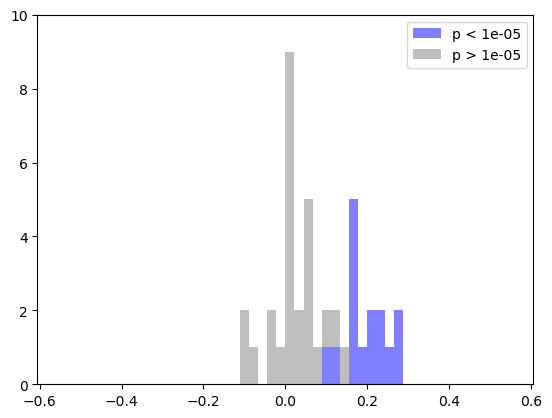

In [29]:
# Manually plot the corrected bonferroni pairs. Kept only the 15 of the significant pairs.

yy,_,_=plt.hist([[ 0.27091439,  0.23773245,  0.16409665,  0.26656127,
        0.17928773,  0.17233493,  0.16280147,  0.24695639,  0.22310325,0.16131123,  0.20791755,  0.16672479,
        0.09280727,  0.19978528,  0.12462259],
                [ 0.08809592,  0.08516248,  0.02808705,  0.05614523,  0.00122674,
       -0.09708689,  0.00822094,  0.01296015,  0.0275998 ,  0.01348121,
       -0.02356396,  0.01363697,  0.00678797, -0.00888553,  0.06035835,
        0.04735236,  0.02161377,  0.01500752,  0.01982156, -0.06780968,
        0.06074713, -0.02373696, -0.09877505, 0.06260503,  0.11245577, 0.14541406]],  color=['blue', 'grey'],
                         stacked=True, bins=hist_bins, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                         label=['p < '+str(significance_level1),
                                'p > '+str(significance_level1)]);
timebin_ylim_mapping[timebin_size][array] = yy.max()+1
plt.ylim(0,yy.max()+1)
plt.legend();
plt.show()

# Correlation Histogram Between FEF-DLPFC (product)

Pancake/20130923/session01/FEF
Pancake/20130923/session01/DLPFC
Pancake/20130923/session01/vDLPFC
Pancake/20130923/session01/FEF Pancake/20130923/session01/vDLPFC 12
12
12
Pancake/20130923/session01/FEF Pancake/20130923/session01/vDLPFC 14
3
3
Pancake/20130923/session01/FEF Pancake/20130923/session01/vDLPFC 17
6
6
Pancake/20130923/session01/FEF Pancake/20130923/session01/vDLPFC 18
4
4
Pancake/20130923/session01/FEF Pancake/20130923/session01/vDLPFC 19
2
2
Pancake/20131014/session01/FEF
Pancake/20131014/session01/DLPFC
Pancake/20131014/session01/vDLPFC
Pancake/20131014/session01/FEF Pancake/20131014/session01/DLPFC 14
1
1
Pancake/20131014/session01/FEF Pancake/20131014/session01/vDLPFC 14
2
2
Pancake/20130927/session01/DLPFC
Pancake/20130927/session01/vDLPFC
James/20140904/session01/vFEF
James/20140904/session01/dFEF
James/20140904/session01/vDLPFC
James/20140904/session01/dDLPFC
James/20140904/session01/vFEF James/20140904/session01/vDLPFC 8
4
4
James/20140904/session01/vFEF James/2014

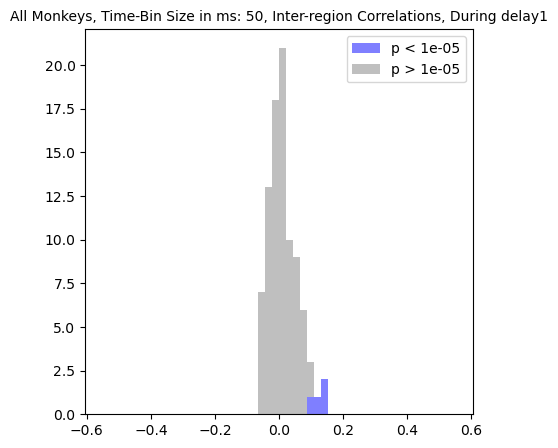

In [35]:
# set significance levels for correlations
significance_level1 = 1e-5#0.00001

plot_title = '{monkey}, Time-Bin Size in ms: {timebin_size}, {arrays}, During {window}'

method = 't-test-locations'
distributions = {}
threshold = 10 # in Hz

hist_bins  = 50
histogram_xrange = [-0.55, 0.55]

for i, timebin_size in enumerate([50]):
    all_low_p = []
    all_high_p = []
    all_medium_p = []

    flatten_pairs = []
    all_low_pairs = []
    all_high_pairs = []

    all_low_pvalues = []
    all_high_pvalues = []
    
    all_low_pair_names = []
    all_high_pair_names = []

    for monkey in ['Pancake', 'James', 'Whiskey']:
        if monkey == 'Pancake':
            region_list = ['FEF', '/DLPFC', 'vDLPFC']
        else:
            region_list = ['vFEF', 'vDLPFC', 'dFEF', 'dDLPFC']
        for session in session_mapping[monkey]:
            zscored_data = {}
            data_spike_counts = {}
            selective = {}
            pair_correlations = []
            p_values_lists = []
            pair_names_lists = []
            # gather the data for each session from all regions
            for session_key in mapped_data_dictionary[timebin_size].keys():
                for region in region_list:
                    if monkey in session_key and session in session_key and region in session_key:
                        print(session_key)
                        # get delay1 data
                        data = mapped_data_dictionary[timebin_size][session_key][:, data_mapping[trial_window][timebin_size][0]:data_mapping[trial_window][timebin_size][1], :]
                        data_labels = mapped_data_dictionary_labels[timebin_size][session_key]
                        timebins = data.shape[1]                        
                        # get the mean of each trial for all neurons to calcualte firing rate
                        data_spike_counts[session_key] = np.sum(data, axis=1)
                        # zscore data per location
                        zscored_data[session_key] = zscore_dataset(data, data_labels)
                        # find selective based on second part of delay1
                        selective[session_key] = get_neuron_selectivity(mapped_data_dictionary[timebin_size][session_key][:, delay1_2_map[timebin_size][0]:delay1_2_map[timebin_size][1], :],
                                                                                                data_labels, method=method, anova_significance_p=0.01, ttest_significance_p=0.01,
                                                                                               prestim_dataset=mapped_data_dictionary[timebin_size][session_key][:, data_mapping['prestim'][timebin_size][0]:data_mapping['prestim'][timebin_size][1], :])
            
            # Collect the stiched zscored trials for all neurons (>10Hz) for all the regions in the list of the monkey
            stiched_zscored_neuron_trials = defaultdict(lambda: defaultdict(list))
            cell_names_ = defaultdict(lambda: defaultdict(list))
            for region in selective.keys():#region_list:
                if region in zscored_data.keys():
                    if zscored_data[region].size!=0:
                        for stim_key in selective[region].keys():
                            for n, neuron in enumerate(selective[region][stim_key]):
                                cell_spike_rate = np.mean(data_spike_counts[region][np.where(data_labels==stim_key)[0], neuron])
                                if cell_spike_rate > threshold:
                                    stiched_zscored_neuron_trials[region][stim_key].append(zscored_data[region][np.where(data_labels==stim_key), :, neuron].reshape(-1))
                                    cell_names_[region][stim_key].append(mapped_cell_names[timebin_size][region][neuron])
            # Calculate the correlation product between the FEF and DLPFC regions (for common locations)
            fef_regions = [region for region in selective.keys() if 'FEF' in region]
            dlpfc_regions = [region for region in selective.keys() if 'DLPFC' in region]
            for region1 in fef_regions:
                for region2 in dlpfc_regions:
                    for stim_key in selective[region1].keys():
                        if stim_key in selective[region2].keys():
                            print(region1, region2, stim_key)
                            nan_idxs1 = np.where(np.isnan(stiched_zscored_neuron_trials[region1][stim_key]))[0]
                            nan_idxs2 = np.where(np.isnan(stiched_zscored_neuron_trials[region2][stim_key]))[0]
                            mask1=np.full(np.array(stiched_zscored_neuron_trials[region1][stim_key]).shape[0], True)
                            mask1[nan_idxs1]=False
                            mask2=np.full(np.array(stiched_zscored_neuron_trials[region2][stim_key]).shape[0], True)
                            mask2[nan_idxs2]=False
                            if mask1.size == 1 and not mask1.any() or mask2.size == 1 and not mask2.any() or mask1.size == 0 or mask2.size == 0:
                                continue
                            pcis, p_values, pair_names = zip(*get_group_pci_product(np.array(stiched_zscored_neuron_trials[region1][stim_key])[mask1,:],
                                                                                    np.array(stiched_zscored_neuron_trials[region2][stim_key])[mask2,:],
                                                                                    [cell_names_[region1][stim_key], cell_names_[region2][stim_key]]))
                            pair_correlations.append(list(pcis))
                            p_values_lists.append(list(p_values))
                            pair_names_lists.append(list(pair_names))
            
            # Gather data and reshape for plotting
            if pair_correlations:
                flatten_pair_correlations = np.array([item for sublist in pair_correlations for item in sublist])
                flatten_p_values = np.array([item for sublist in p_values_lists for item in sublist])
                flatten_pair_names = np.array([item for sublist in pair_names_lists for item in sublist])
                # split pair correlations based on p value
                low_p = flatten_pair_correlations[np.where(flatten_p_values<=significance_level1)]
                high_p = flatten_pair_correlations[np.where(flatten_p_values>significance_level1)]

                all_low_p.append(low_p)
                all_high_p.append(high_p)

                all_low_pvalues.append(flatten_p_values[np.where(flatten_p_values<=significance_level1)])
                all_high_pvalues.append(flatten_p_values[np.where(flatten_p_values>significance_level1)])
                
                all_low_pair_names.append(flatten_pair_names[np.where(flatten_p_values<=significance_level1)])
                all_high_pair_names.append(flatten_pair_names[np.where(flatten_p_values>significance_level1)])
                
                
    all_low_p_flatten = np.array([item for sublist in all_low_p for item in sublist])
    all_high_p_flatten = np.array([item for sublist in all_high_p for item in sublist])

    all_low_pvalues_flatten =  np.array([item for sublist in all_low_pvalues for item in sublist])
    all_high_pvalues_flatten = np.array([item for sublist in all_high_pvalues for item in sublist])
    
    all_low_pairs_flatten =  np.array([item for sublist in all_low_pair_names for item in sublist])
    all_high_pairs_flatten = np.array([item for sublist in all_high_pair_names for item in sublist])
    
    plt.figure(figsize=(5,5))
    plt.title(plot_title.format(monkey='All Monkeys', timebin_size=timebin_size, arrays='Inter-region Correlations', window=trial_window),
                      fontdict = {'fontsize' : 10})
    plt.hist([all_low_p_flatten, all_high_p_flatten], color=['blue', 'grey'],
             stacked=True, bins=hist_bins, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
             label=['p < '+str(significance_level1),
                    'p > '+str(significance_level1)]);
    plt.legend();
    plt.show()

# After Bonferroni correction

In [36]:
all_low_p_flatten

array([0.14795135, 0.10340197, 0.11686238, 0.15326978])

In [37]:
all_high_p_flatten

array([ 0.0535228 , -0.00378161,  0.0932576 , -0.0012435 , -0.00284924,
        0.01980405, -0.01030693,  0.0056346 ,  0.08291427, -0.02546934,
       -0.03434358, -0.04781082, -0.01209813, -0.02562094,  0.04497618,
        0.06108121,  0.03700123,  0.0696442 ,  0.07840052,  0.04087678,
       -0.06438032,  0.00917968, -0.00476067,  0.09892675, -0.00754974,
        0.01130415,  0.03894974, -0.01574471, -0.01522748, -0.03684712,
        0.07235192, -0.02440584,  0.06230207,  0.00471181,  0.07721916,
        0.04983615, -0.00433848, -0.00649142, -0.02633059,  0.0248824 ,
        0.00790325, -0.01441534, -0.05112611,  0.01762675, -0.02312112,
        0.04914925,  0.03807351, -0.00665118, -0.0517368 , -0.05535607,
        0.01982574,  0.02562171, -0.04505416,  0.01569355, -0.00818453,
       -0.03476121,  0.06664626, -0.03574872,  0.01065463,  0.00805271,
        0.01374276, -0.054981  , -0.01095068,  0.02524662, -0.03286398,
       -0.02982888,  0.01046569,  0.0532532 , -0.01799129, -0.02

In [38]:
significance_level1 = 1e-5

smt.multipletests(np.concatenate([all_low_pvalues_flatten,
                                 all_high_pvalues_flatten]),
                  alpha=significance_level1,
                  method='bonferroni')

(array([ True, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([3.79880954e-06, 1.58669861e-05, 4.61555257e-06, 7.17849871e-11,
        1.00000000e+00, 1.00000000e+00, 1.68587050e-02, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        8.11039545e-02, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,


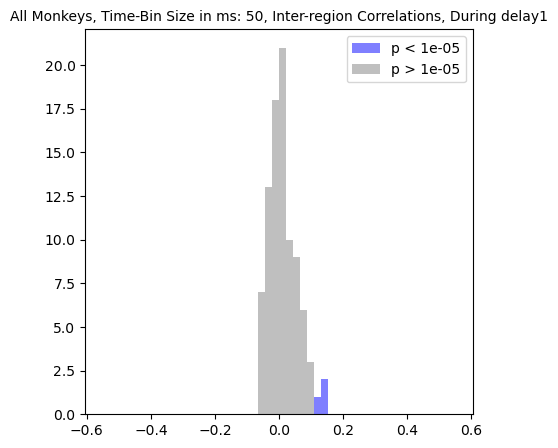

In [39]:
# Manually plot the bonferroni corrected pairs. Kept only 3 significant
plt.figure(figsize=(5,5))
plt.title(plot_title.format(monkey='All Monkeys', timebin_size=timebin_size, arrays='Inter-region Correlations', window=trial_window),
                  fontdict = {'fontsize' : 10})
plt.hist([[0.14795135, 0.11686238, 0.15326978],
          [ 0.0535228 , -0.00378161,  0.0932576 , -0.0012435 , -0.00284924,
        0.01980405, -0.01030693,  0.0056346 ,  0.08291427, -0.02546934,
       -0.03434358, -0.04781082, -0.01209813, -0.02562094,  0.04497618,
        0.06108121,  0.03700123,  0.0696442 ,  0.07840052,  0.04087678,
       -0.06438032,  0.00917968, -0.00476067,  0.09892675, -0.00754974,
        0.01130415,  0.03894974, -0.01574471, -0.01522748, -0.03684712,
        0.07235192, -0.02440584,  0.06230207,  0.00471181,  0.07721916,
        0.04983615, -0.00433848, -0.00649142, -0.02633059,  0.0248824 ,
        0.00790325, -0.01441534, -0.05112611,  0.01762675, -0.02312112,
        0.04914925,  0.03807351, -0.00665118, -0.0517368 , -0.05535607,
        0.01982574,  0.02562171, -0.04505416,  0.01569355, -0.00818453,
       -0.03476121,  0.06664626, -0.03574872,  0.01065463,  0.00805271,
        0.01374276, -0.054981  , -0.01095068,  0.02524662, -0.03286398,
       -0.02982888,  0.01046569,  0.0532532 , -0.01799129, -0.02347131,
       -0.02666163,  0.00896231,  0.02687819, -0.01422779,  0.00755814,
        0.04854043,  0.04764775,  0.04068418, -0.00888786,  0.00018057,
        0.01723857,  0.01206576,  0.0128815 ,  0.02398306,  0.00295782,
        0.01842519, 0.10340197]], color=['blue', 'grey'],
         stacked=True, bins=hist_bins, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
         label=['p < '+str(significance_level1),
                'p > '+str(significance_level1)]);
plt.legend();
plt.show()

# Fano Factor Analysis

Mean FF:  1.2707655988838369
Median FF:  1.1401286639992252


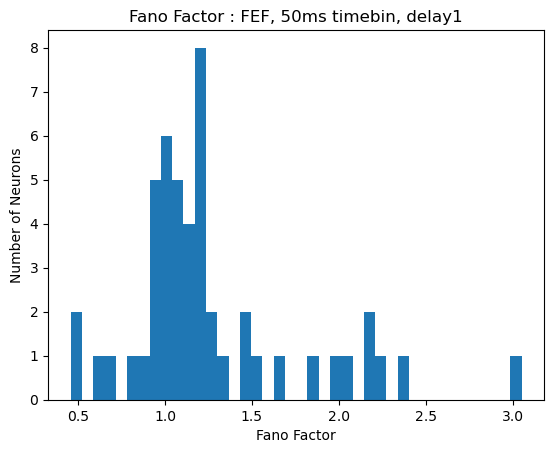

Mean FF:  1.007168490927066
Median FF:  1.0869976335318166


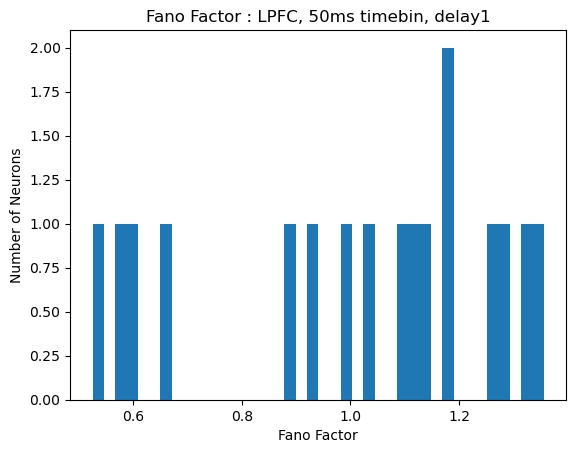

In [41]:
fano_factors = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

idx = 0
ff_medians = defaultdict(list)
ff_means = defaultdict(list)
for timebin_size in [50]:
    for area in ['FEF', 'LPFC']:
        for window in ['delay1']:
            for n in all_neurons[timebin_size][area][window]:
                
                fano_factors[timebin_size][area][window].append(np.mean(np.var(n, axis=0)/np.mean(n, axis=0)))

            ff_mean = np.nanmean(fano_factors[timebin_size][area][window])
            ff_median = np.nanmedian(fano_factors[timebin_size][area][window])
            ff_means[area].append(ff_mean)
            ff_medians[area].append(ff_median)
            print("Mean FF: ", ff_mean)
            print("Median FF: ", ff_median)
            plt.figure()
            plt.hist(fano_factors[timebin_size][area][window], bins=40)
            plt.title("Fano Factor : "+area+', '+str(timebin_size)+'ms timebin, '+window)
            plt.xlabel("Fano Factor")
            plt.ylabel("Number of Neurons")
            
            plt.show()    
